In [1]:
from copy import copy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

from numpy.random import default_rng
from scipy.stats import norm, truncnorm

In [2]:
print(pm.__version__)

4.1.1


In [4]:
%config InlineBackend.figure_format = 'retina'
rng = default_rng(12345)
az.style.use("arviz-darkgrid")

In [5]:
slope, intercept, σ, N = 1, 0, 2, 200
x = rng.uniform(-10, 10, N)
y = rng.normal(loc=slope * x + intercept, scale=σ)

In [6]:
def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])

In [7]:
def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])

In [8]:
def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y <= bounds[0]] = bounds[0]
    cy[y >= bounds[1]] = bounds[1]
    return (x, cy)

In [9]:
bounds = [-5, 5]
xt, yt = truncate_y(x, y, bounds)
xc, yc = censor_y(x, y, bounds)

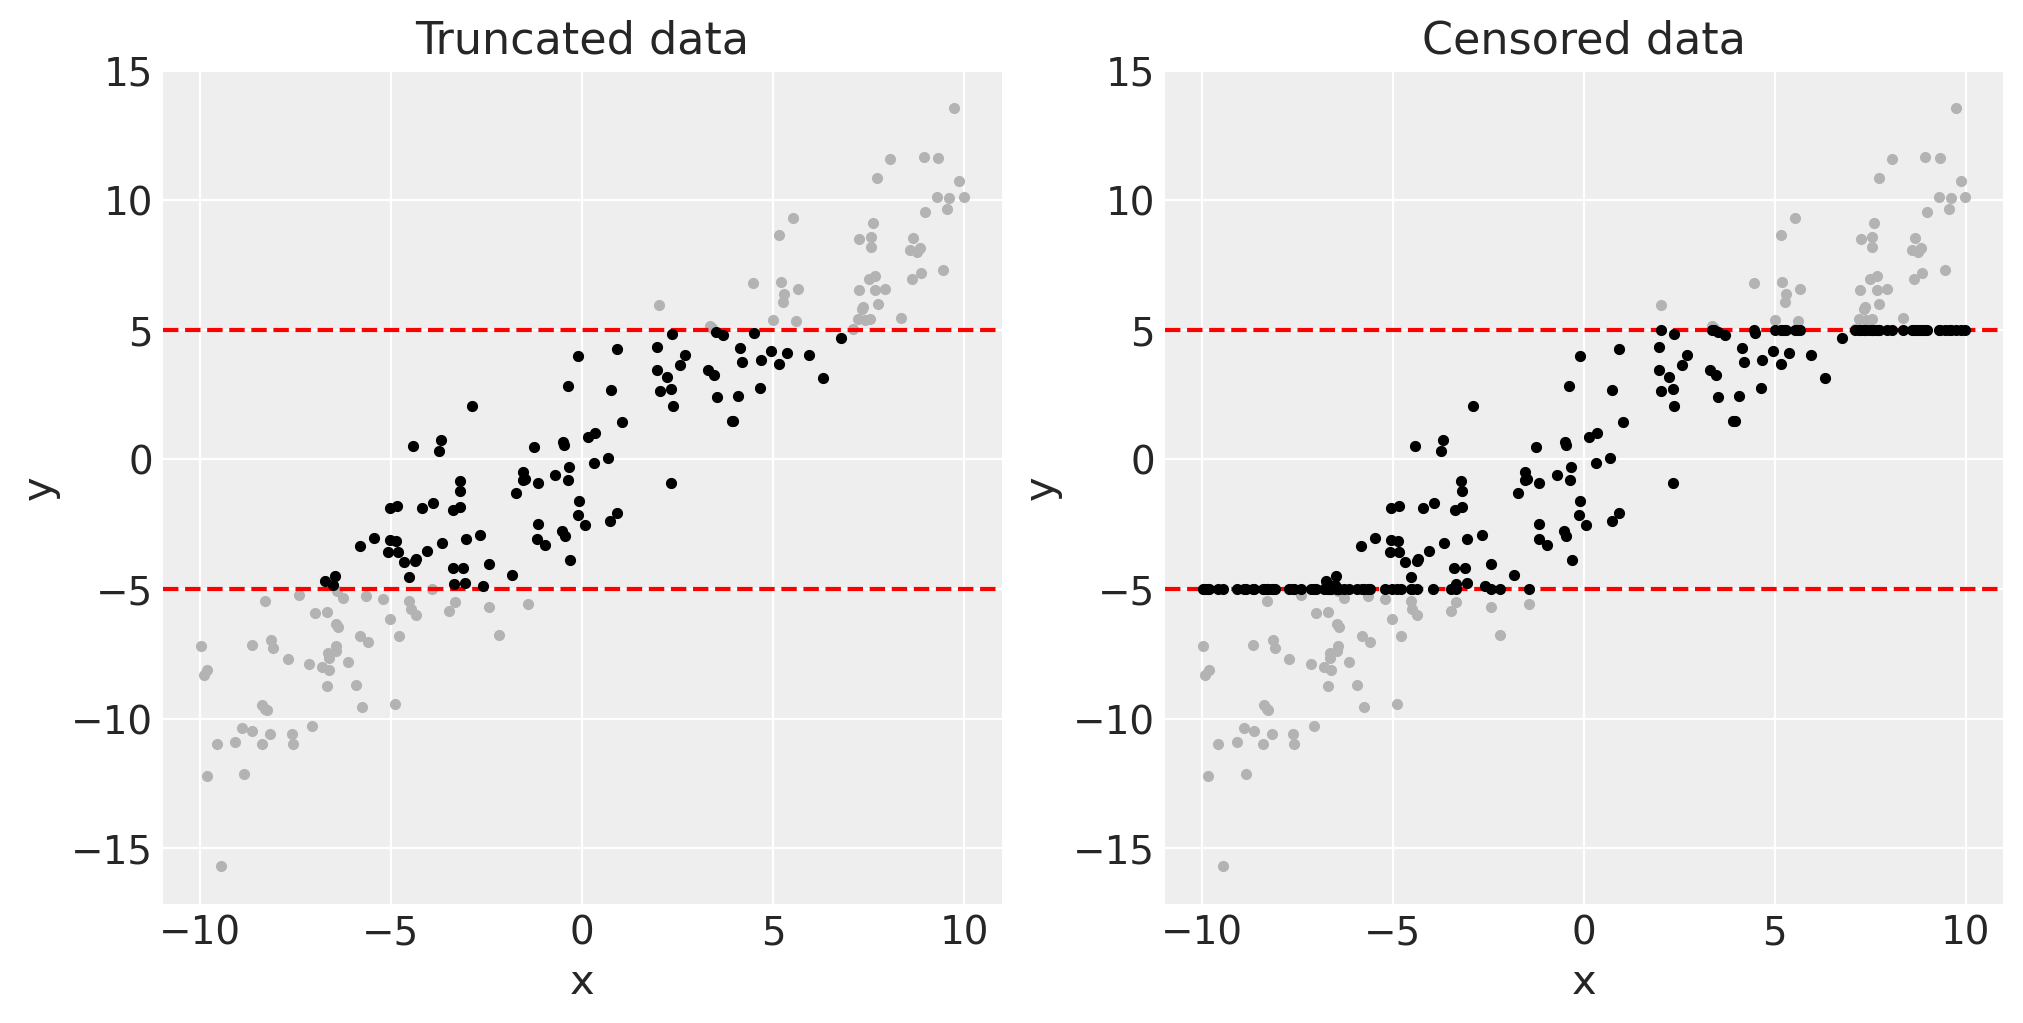

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax in axes:
    ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
    ax.axhline(bounds[0], c="r", ls="--")
    ax.axhline(bounds[1], c="r", ls="--")
    ax.set(xlabel="x", ylabel="y")

axes[0].plot(xt, yt, ".", c=[0, 0, 0])
axes[0].set(title="Truncated data")

axes[1].plot(xc, yc, ".", c=[0, 0, 0])
axes[1].set(title="Censored data");

In [11]:
def truncated_regression(x, y, bounds):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        σ = pm.HalfNormal("σ", sigma=1)

        pm.TruncatedNormal(
            "obs",
            mu=slope * x + intercept,
            sigma=σ,
            observed=y,
            lower=bounds[0],
            upper=bounds[1],
        )
    return model

In [12]:
trunc_linear_model = linear_regression(xt, yt)

with trunc_linear_model:
    trunc_linear_fit = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
